# **Analysis of Mean Change, Standard Deviation, and Temperature Distributions in Cold Regions Due to Pixel Size Change and Alignment Rotations**

## This is a preliminary exploration; a more detailed analysis can be found in the alignment article and my thesis, the links to which are available in the document's readme.

## Last modified: F.J Ordoñez A,  11.24.2023 
## email: fjordoneza@unal.edu.co

In [2]:
from skimage.transform import rescale
from astropy.coordinates import SkyCoord
from datetime import date, datetime,timedelta
from  scipy.stats.stats import pearsonr
from skimage.metrics import structural_similarity as ssim
from sunpy.coordinates import RotatedSunFrame
import sunpy.coordinates.frames as f
import matplotlib.pyplot as plt
import scipy.ndimage as scnd
from astropy.io import fits
import astropy.units as u
from scipy import signal
from function_used import *  #file where is some usefulls functions 
import numpy as np
import sunpy.map
import matplotlib
import warnings
import salat
import numpy.ma as ma
import glob
from tqdm import tqdm
import pandas as pd
import os
warnings.filterwarnings("ignore")

/tmp/ipykernel_21268/2340177478.py:4: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from  scipy.stats.stats import pearsonr


In [3]:
path_ALMA='/media/javier/SSD_2/OtrasRegiones/{}'
file=path_ALMA.format('D06_solaralma.b3.fba.20180412_155228-162441.2017.1.00653.S.level4.k.fits')
almacube, header, timesec, timeutc, beammajor, beamminor, beamangle = salat.read(file,timeout=True,beamout=True,HEADER=True,SILENT=False,fillNan=True)
# Rotating ALMA cube
alma_rote=fun_alma_rotate(almacube,header)


---------------------------------------------------
--------------- SALAT READ part of ----------------
-- Solar Alma Library of Auxiliary Tools (SALAT) --

Reading ALMA cube



100%|██████████| 1608/1608 [00:01<00:00, 1149.30it/s]


---------------------------------------------------
--------------- SALAT INFO part of ----------------
-- Solar Alma Library of Auxiliary Tools (SALAT) --


----------------------------------------------
| Data feat.: 
----------------------------------------------
|  ALMA BAND:  3
|  Obs. Date:  2018-04-12
|  ALMA proj:  2017.1.00653.S
|  Pix. Unit:  K
|  Pix. Size:  0.3  arcsec.
|  Beam mean:  2.15798  arcsec
|  FOV. diam:  notcomputed
----------------------------------------------
| Data range 
----------------------------------------------
|  Min =  5260.81054688  Kelvin
|  Max =  10677.8203125  Kelvin
----------------------------------------------

Done!
Rotating ALMA cube


100%|██████████| 1608/1608 [00:14<00:00, 109.55it/s]


rotate angle -26.1446


In [5]:
result          = pd.read_excel('results_alignment.xlsx')
parameters      = pd.read_excel('parameters.xlsx')
parameters
#parameters.iloc[4][1]

,ALMA,Unnamed: 1,SDO,Unnamed: 3
0,Tx_helioprojective,-128.0,t_0_SDO\n(YYYY-MM-DDTHH:MM:SS),2018-04-12 15:35:28
1,Ty_helioprojective,-400.0,t_f_SDO\n(YYYY-MM-DDTHH:MM:SS),2018-04-12 15:37:28
2,x_size_snapshot,253.0,radio_crop_sdo,68.31
3,y_size_snapshot,253.0,NaN,NaN
4,ALMA_pix_size (arcsec),0.3,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,"Must t_0, t_f must be chosen \nIn the same ALM...",NaN,NaN,NaN
8,Radio_crop: were chosen so that it had\nA larg...,NaN,NaN,NaN


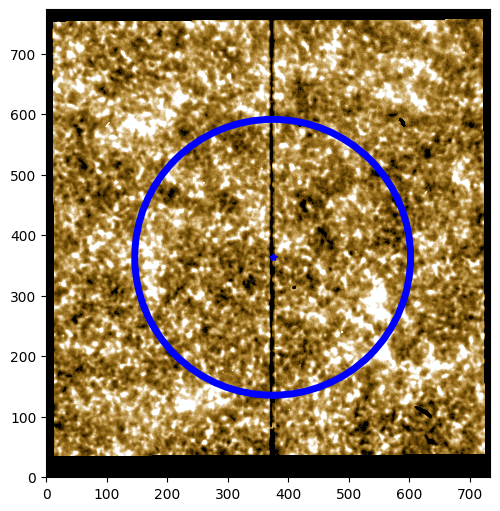

In [6]:
#mask_alma=alma_rote[0].copy()
#mask_alma[mask_alma>7000] =0
#mask_alma[mask_alma>0]=1

# Reading IRIS FILE 
path_iris='IRIS/{}'
iris_2796=fits.open(path_iris.format('iris_l2_20180412_130937_3640258010_SJI_2796_t000.fits'))
iris_1330=fits.open(path_iris.format('iris_l2_20180412_130937_3640258010_SJI_1330_t000.fits'))
iris_1400=fits.open(path_iris.format('iris_l2_20180412_130937_3640258010_SJI_1400_t000.fits'))
iris_2832=fits.open(path_iris.format('iris_l2_20180412_130937_3640258010_SJI_2832_t000.fits'))

path_result= 'result_align/{}'
result_iris_2796 = np.load(path_result.format('crop_and_aling_iris_2796_Pixel_ALMA_size.npy'))
result_iris_2832 = np.load(path_result.format('crop_and_aling_iris_2832_Pixel_ALMA_size.npy'))
result_iris_1400 = np.load(path_result.format('crop_and_aling_iris_1400_Pixel_ALMA_size.npy'))
result_iris_1330 = np.load(path_result.format('crop_and_aling_iris_1330_Pixel_ALMA_size.npy'))
#aperture            = aperture_circ_ALMA(almacube)

vmin_2796 = np.percentile(iris_2796[0].data[266],11) 
vmax_2796 = np.percentile(iris_2796[0].data[266],95) 
fig, ax =plt.subplots(figsize=(5,5), dpi=100, ncols=1, nrows=1,  constrained_layout=True,sharex=True, sharey=True,gridspec_kw = {'wspace':0, 'hspace':0})
ax.imshow(iris_2796[0].data[266],vmin=vmin_2796 , vmax=vmax_2796,origin='lower',cmap='irissji2796')
ax.plot(result.iloc[0][2], result.iloc[1][2], 'b*')
scale = parameters.iloc[4][1]/iris_2796[0].header['CDELT1']
radio = (parameters.iloc[2][1]/2)*scale
curculo_1=matplotlib.patches.Circle(( result.iloc[0][2], result.iloc[1][2],'b*'),radio,ec='blue', fc='none',lw=5)
ax.add_patch(curculo_1)

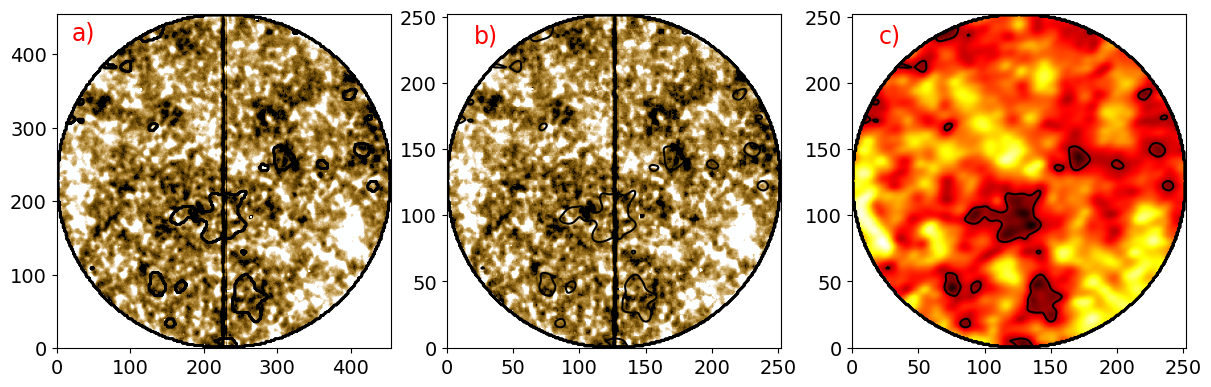

<Figure size 1400x1400 with 0 Axes>

In [53]:
x_resul_iris, y_resul_iris = result.iloc[0][2], result.iloc[1][2]
threshold =alma_rote[0][0][0].copy() -1.5*650.2055766101175
mask_alma=alma_rote[0].copy()
mask_alma[mask_alma>threshold] =0
mask_alma[mask_alma>0]=1
mask_rescale        = rescale(mask_alma, scale, order=0, anti_aliasing=False, preserve_range=True)
aperture            = aperture_circ_ALMA(almacube)
mask_aperture       = rescale(aperture, scale, order=0, anti_aliasing=False, preserve_range=True)
radio = (253/2)*scale
x_0   = int(x_resul_iris-radio)
x_f   = int(x_resul_iris+radio)
y_0   = int(y_resul_iris-radio)
y_f   = int(y_resul_iris+radio)


fig, ax=plt.subplots(figsize=(12,8), dpi=100, ncols=3, nrows=1,  constrained_layout=True,gridspec_kw = {'wspace':0, 'hspace':0})

plt.figure(figsize=(14,14))


fontsize_word=13

prueba_mask= iris_2796[0].data[266][y_0:y_f, x_0:x_f]*mask_aperture .copy()
prueba_mask[prueba_mask==0]=None

ax[0].imshow(prueba_mask , vmin =np.nanpercentile(prueba_mask,5), vmax =np.nanpercentile(prueba_mask,90) ,cmap='irissji2796',origin='lower')
ax[0].contour(mask_aperture, colors='black')
ax[0].contour(mask_rescale, colors='black')

prueba_mask_2 = result_iris_2796[0]*aperture .copy()
prueba_mask_2 [prueba_mask_2==0]=None

ax[1].imshow( prueba_mask_2 ,vmin =np.nanpercentile(prueba_mask,5), vmax =np.nanpercentile(prueba_mask,90) ,origin='lower',cmap='irissji2796')
ax[1].contour(alma_rote[0],   levels=[threshold] , colors='black')
ax[1].contour(aperture, colors='black')

mask_plot_alma = alma_rote[0].copy()
mask_plot_alma[mask_plot_alma==mask_plot_alma[0][0]]=None

ax[2].imshow(mask_plot_alma,origin='lower',cmap='hot')
ax[2].contour(alma_rote[0],   levels=[threshold] , colors='black')
ax[2].contour(aperture, colors='black')


ax[0].text(20, 420, 'a)',fontsize = fontsize_word+4, color="red")
ax[1].text(20, 230, 'b)',fontsize = fontsize_word+4, color="red")
ax[2].text(20, 230, 'c)',fontsize = fontsize_word+4, color="red")

#fontsize_word = 10
for axs in ax.flat:
    axs.set_xticklabels(axs.get_xticklabels(), fontsize=fontsize_word+1)
    axs.set_yticklabels(axs.get_yticklabels(), fontsize=fontsize_word+1)


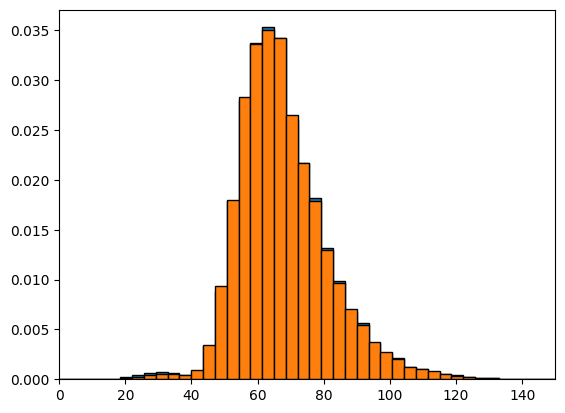

In [54]:
mask_original_data = ma.masked_where(prueba_mask.flatten() == None ,prueba_mask.flatten() )
mask_scaled_data   = ma.masked_where(prueba_mask_2.flatten() == None ,prueba_mask_2.flatten() )

n  , bins  , patches   = plt.hist(mask_scaled_data.copy(), bins=100  , density=True, edgecolor='black')
n_2, bins_2, patches_2 = plt.hist(mask_original_data.copy(), bins=100, density=True, edgecolor='black')
plt.xlim(0,150)
# Normalizamos el histograma
n_norm = n / np.max(n)

n_norm_2 = n_2 / np.max(n_2)


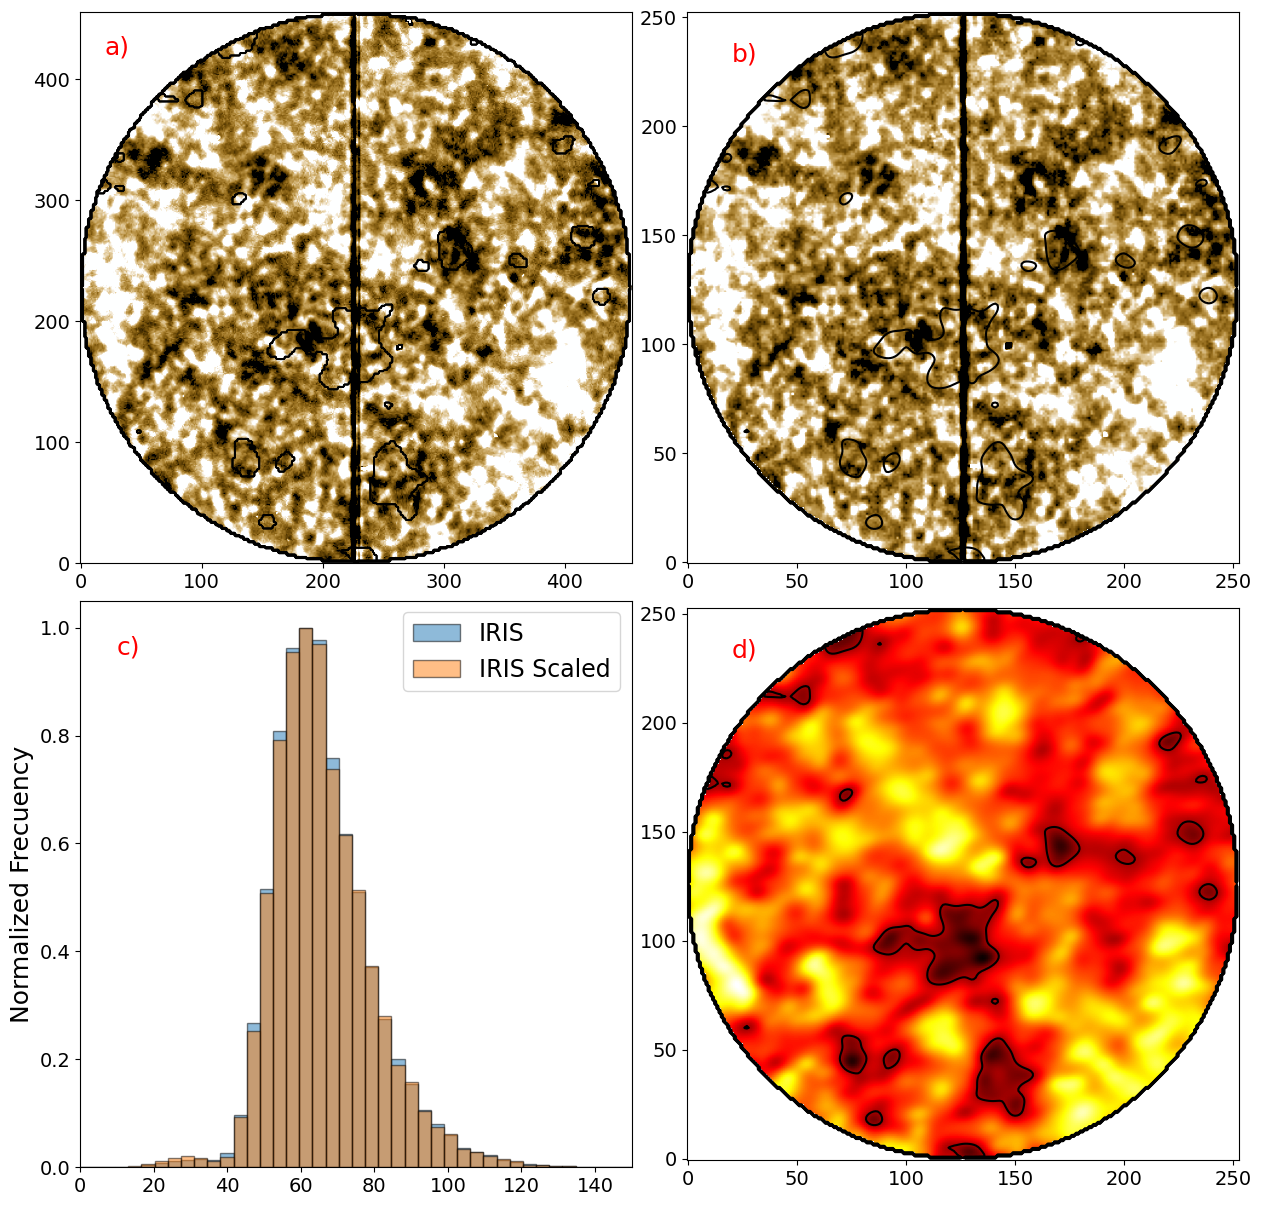

In [71]:
#fig, ax=plt.subplots(figsize=(12,12), dpi=100, ncols=2, nrows=2,  constrained_layout=True,gridspec_kw = {'wspace':0, 'hspace':0})
fig, ax=plt.subplots(figsize=(12.5,12), dpi=100, ncols=2, nrows=2,  constrained_layout=True,gridspec_kw = {'wspace':0, 'hspace':0})

#plt.figure(figsize=(14,14))


fontsize_word=13

prueba_mask= iris_2796[0].data[266][y_0:y_f, x_0:x_f]*mask_aperture .copy()
prueba_mask[prueba_mask==0]=None

ax[0,0].imshow(prueba_mask , vmin =np.nanpercentile(prueba_mask,5), vmax =np.nanpercentile(prueba_mask,85) ,cmap='irissji2796',origin='lower')
ax[0,0].contour(mask_aperture, colors='black')
ax[0,0].contour(mask_rescale , colors='black', linewidths=0.7)

prueba_mask_2 = result_iris_2796[0]*aperture .copy()
prueba_mask_2 [prueba_mask_2==0]=None

ax[0,1].imshow( prueba_mask_2 ,vmin =np.nanpercentile(prueba_mask,5), vmax =np.nanpercentile(prueba_mask,85) ,origin='lower',cmap='irissji2796')
ax[0,1].contour(alma_rote[0],   levels=[threshold] , colors='black')
ax[0,1].contour(aperture, colors='black')

mask_plot_alma = alma_rote[0].copy()
mask_plot_alma[mask_plot_alma==mask_plot_alma[0][0]]=None

ax[1,1].imshow(mask_plot_alma,origin='lower',cmap='hot')
ax[1,1].contour(alma_rote[0],   levels=[threshold] , colors='black')
ax[1,1].contour(aperture, colors='black')


ax[1,0].bar(bins_2[:-1], n_norm_2, width=np.diff(bins_2), edgecolor='black', alpha=0.5,label='IRIS')
ax[1,0].bar(bins[:-1]  , n_norm  , width=np.diff(bins)  , edgecolor='black', alpha=0.5,label='IRIS Scaled')
ax[1,0].set_xlim(0,150)
ax[1,0].legend(fontsize = fontsize_word+4)

ax[1,0].set_ylabel('Normalized Frecuency' , fontsize = fontsize_word+5)

ax[0,0].text(20, 420, 'a)',fontsize = fontsize_word+5, color="red")
ax[0,1].text(20, 230, 'b)',fontsize = fontsize_word+5, color="red")
ax[1,1].text(20, 230, 'd)',fontsize = fontsize_word+5, color="red")
ax[1,0].text(10, 0.95,'c)',fontsize = fontsize_word+5, color="red")

#fontsize_word = 10
for axs in ax.flat:
    axs.set_xticklabels(axs.get_xticklabels(), fontsize=fontsize_word+1)
    axs.set_yticklabels(axs.get_yticklabels(), fontsize=fontsize_word+1)
plt.savefig('iris_data_analisis_scaled.jpg',dpi=120)
plt.show()

In [63]:
time_vec_iris =  creating_time_vector(iris_1330)
n_0, n_f= find_nearest(time_vec_iris, timeutc[0], timeutc[-1], 'IRIS', 'ALMA')
time_vec_iris = creating_time_vector(iris_1330)[n_0:n_f]


def mean_std_analisis(iris_data, iris_time_cut, iris_rescale ,  alma_data, alma_time, threshold):
    scale                      = parameters.iloc[4][1]/iris_data[0].header['CDELT1']
    aperture                   = aperture_circ_ALMA(alma_data)
    aperture_rescaled          = rescale(aperture, scale, order=0, anti_aliasing=False, preserve_range=True)
    x_resul_iris, y_resul_iris = result.iloc[0][2], result.iloc[1][2]
    threshold = alma_rote[0][0][0].copy() -650.2055766101175
    radio = (parameters.iloc[2][1]/2)*scale
    x_0   = int(x_resul_iris-radio)
    x_f   = int(x_resul_iris+radio)
    y_0   = int(y_resul_iris-radio)
    y_f   = int(y_resul_iris+radio)

    mean_scaled  , std_scaled    = [],[]
    mean_data_ori, std_data_ori  = [],[]
    discre_mean  , discre_sdt    = [],[]

    for i in range(0,len(iris_time_cut),1):
        ind=find_nearest_modificated(alma_time, iris_time_cut[i])
        #print(ind)
        mask_alma=alma_rote[ind].copy()
        mask_alma[mask_alma>threshold] =0
        mask_alma[mask_alma>0]=1
        mask_rescale        = rescale(mask_alma, scale, order=0, anti_aliasing=False, preserve_range=True)
        
        x=iris_data[0].data[n_0+i][y_0:y_f, x_0:x_f]*aperture_rescaled*mask_rescale

        y= iris_rescale[i]*aperture*mask_alma

        mean_x_orin =  ma.masked_where(x==0.0, x)
        mean_data_ori.append(mean_x_orin.mean()) 
        std_data_ori.append( mean_x_orin.std()) 

        mean_x_scaled =  ma.masked_where(y==0.0, y)
        mean_scaled.append(mean_x_scaled.mean())
        std_scaled.append(mean_x_scaled.std()) 

        df_mean=np.abs(mean_x_orin.mean() -mean_x_scaled.mean())
        max_mean = max(mean_x_orin.mean(), mean_x_scaled.mean())
        discre_mean.append(df_mean*100/max_mean)  
        
        df_std =  np.abs(mean_x_orin.std() -mean_x_scaled.std())
        discre_sdt.append( df_std *100/max(mean_x_orin.std(),mean_x_scaled.std())) 
    '''
    plt.figure(figsize=(16,5))
    plt.subplot(131)
    plt.title('IRIS {}'.format(int(iris_data[0].header['TWAVE1'])))
    plt.plot(mean_scaled   , label='Scaled Mean')
    plt.plot(mean_data_ori , label='NO scaled Mean')
    plt.ylabel('Mean')
    plt.legend()
    plt.subplot(132)
    plt.title('IRIS {}'.format(int(iris_data[0].header['TWAVE1'])))
    plt.plot(std_scaled  , label='Scaled STD')
    plt.ylabel('STD')
    plt.plot(std_data_ori, label='NO scaled STD')
    plt.legend()
    plt.subplot(133)   
    plt.plot(discre_mean, label='Discre Mean' , color = 'r')
    plt.plot(discre_sdt , label='Discre STD' , color = 'b')
    
    plt.axhline(y = np.mean(np.array(discre_sdt)) , color = 'b', linestyle  = '--')
    plt.axhline(y = np.mean(np.array(discre_mean)), color = 'r', linestyle = '--')
    plt.legend()
    plt.show()
    '''
    return mean_scaled  , std_scaled  , mean_data_ori, std_data_ori ,discre_mean  , discre_sdt  


______________________________________________________
t_0_IRIS = 2018-04-12 15:52:18.956000
t_0_ALMA= 2018-04-12 15:52:31.992187
______________________________________________________
t_f_IRIS = 2018-04-12 16:24:43.844000
t_0_ALMA= 2018-04-12 16:24:40.246093
______________________________________________________
posicion_n_0: 266 | posicion_n_f: 319
______________________________________________________


In [64]:
mean_scaled_1  , std_scaled_1  , mean_data_ori_1 , std_data_ori_1 ,discre_mean_1  , discre_sdt_1 =    mean_std_analisis( iris_2796,time_vec_iris,  result_iris_2796,  almacube, timeutc, threshold)
mean_scaled_2  , std_scaled_2  , mean_data_ori_2 , std_data_ori_2 ,discre_mean_2  , discre_sdt_2 =    mean_std_analisis( iris_1330,time_vec_iris,  result_iris_1330,  almacube, timeutc, threshold)
mean_scaled_3  , std_scaled_3  , mean_data_ori_3 , std_data_ori_3 ,discre_mean_3  , discre_sdt_3 =    mean_std_analisis( iris_1400,time_vec_iris,  result_iris_1400,  almacube, timeutc, threshold)
mean_scaled_4  , std_scaled_4  , mean_data_ori_4 , std_data_ori_4 ,discre_mean_4  , discre_sdt_4 =    mean_std_analisis( iris_2832,time_vec_iris,  result_iris_2832,  almacube, timeutc, threshold)

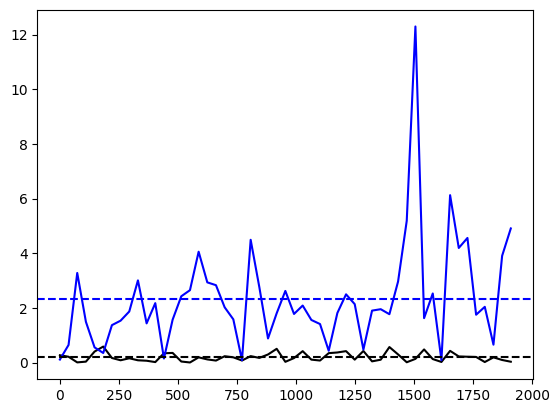

In [60]:
plt.plot(time_data             , discre_mean_1    , label=name_iris_scaled  , color='black')
plt.plot(time_data             ,  discre_sdt_1    , label= name_iris       , color='blue')
plt.axhline(y = np.mean(np.array(discre_mean_1)) ,  color='black', linestyle  = '--', label='Mean Error')
plt.axhline(y = np.mean(np.array( discre_sdt_1))  , color='blue'  , linestyle = '--' , label='Std Error')


In [14]:
cadende = (time_vec_iris[1]- time_vec_iris[0]).total_seconds()

In [16]:
time_data = np.arange(0, len(mean_scaled_1)*cadende, cadende)

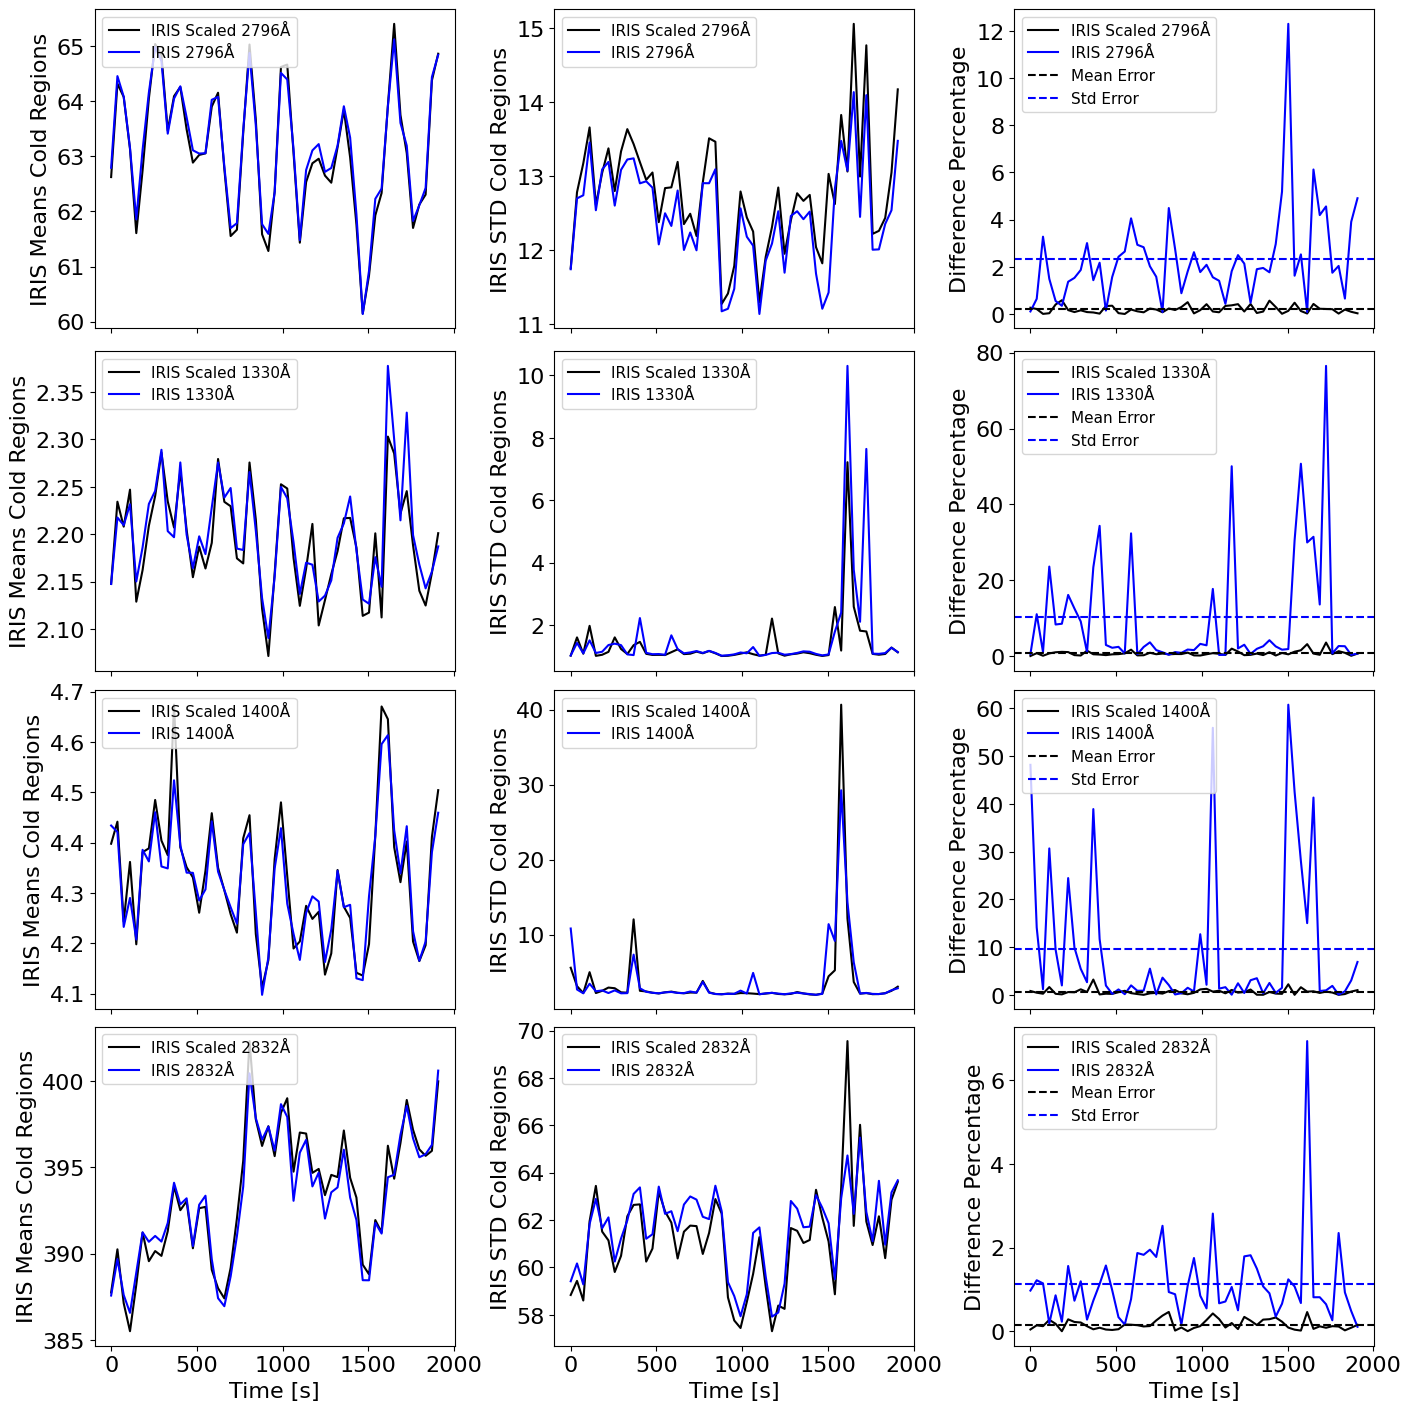

In [67]:
fig, ax=plt.subplots(figsize=(14,14), dpi=100, ncols=3, nrows=4,  constrained_layout=True, sharex=True,gridspec_kw = {'wspace':0, 'hspace':0})
name_iris_scaled='IRIS Scaled 2796Å'
name_iris='IRIS 2796Å'

fontsize_word=11

ax[0,0].plot(time_data,   mean_scaled_1   , label=name_iris_scaled , color='black')
ax[0,0].plot(time_data, mean_data_ori_1   , label= name_iris       , color='blue') 

ax[0,1].plot(time_data ,  std_scaled_1    , label=name_iris_scaled , color='black')
ax[0,1].plot(time_data ,std_data_ori_1    , label= name_iris       , color='blue')


ax[0,2].plot(time_data,  discre_mean_1    , label=name_iris_scaled  , color='black')
ax[0,2].plot(time_data,  discre_sdt_1       , label= name_iris       , color='blue')

ax[0,2].axhline(y = np.mean(np.array(discre_mean_1)) ,  color='black', linestyle  = '--', label='Mean Error')
ax[0,2].axhline(y = np.mean(np.array(discre_sdt_1))  , color='blue'  , linestyle = '--' , label='Std Error')



name_iris_scaled='IRIS Scaled 1330Å'
name_iris='IRIS 1330Å'

ax[1,0].plot(time_data,   mean_scaled_2   , label=name_iris_scaled , color='black')
ax[1,0].plot(time_data, mean_data_ori_2   , label= name_iris       , color='blue') 

ax[1,1].plot(time_data,   std_scaled_2    , label=name_iris_scaled , color='black')
ax[1,1].plot(time_data, std_data_ori_2    , label= name_iris       , color='blue')


ax[1,2].plot(time_data, discre_mean_2    , label=name_iris_scaled  , color='black')
ax[1,2].plot(time_data,  discre_sdt_2    , label= name_iris       , color='blue')

ax[1,2].axhline(y = np.mean(np.array(discre_mean_2)) ,  color='black', linestyle  = '--', label='Mean Error')
ax[1,2].axhline(y = np.mean(np.array(discre_sdt_2))  , color='blue'  , linestyle = '--' , label='Std Error')



name_iris_scaled='IRIS Scaled 1400Å'
name_iris='IRIS 1400Å'

ax[2,0].plot(time_data,   mean_scaled_3   , label=name_iris_scaled , color='black')
ax[2,0].plot(time_data, mean_data_ori_3   , label= name_iris       , color='blue') 

ax[2,1].plot(time_data,   std_scaled_3    , label=name_iris_scaled , color='black')
ax[2,1].plot(time_data, std_data_ori_3    , label= name_iris       , color='blue')


ax[2,2].plot(time_data, discre_mean_3    , label=name_iris_scaled  , color='black')
ax[2,2].plot(time_data,  discre_sdt_3    , label= name_iris       , color='blue')

ax[2,2].axhline(y = np.mean(np.array(discre_mean_3)) ,  color='black', linestyle  = '--', label='Mean Error')
ax[2,2].axhline(y = np.mean(np.array(discre_sdt_3))  , color='blue'  , linestyle = '--' , label='Std Error')



name_iris_scaled='IRIS Scaled 2832Å'
name_iris='IRIS 2832Å'

ax[3,0].plot(time_data,  mean_scaled_4   , label=name_iris_scaled , color='black')
ax[3,0].plot(time_data,mean_data_ori_4   , label= name_iris       , color='blue') 

ax[3,1].plot(time_data,   std_scaled_4    , label=name_iris_scaled , color='black')
ax[3,1].plot(time_data, std_data_ori_4    , label= name_iris       , color='blue')

#ax[3,2].plot(time_data, discre_mean_4    , label=name_iris_scaled  , color='black')
#ax[3,2].plot(time_data,  discre_sdt_4    , label= name_iris       , color='blue')
#ax[3,2].axhline(y = np.mean(np.array(discre_mean_4)) ,  color='black', linestyle  = '--', label='Mean Error')
#ax[3,2].axhline(y = np.mean(np.array(discre_sdt_4))  , color='blue'  , linestyle = '--' , label='Std Error')



ax[3,2].plot(time_data             , discre_mean_4    , label=name_iris_scaled  , color='black')
ax[3,2].plot(time_data             ,  discre_sdt_4    , label= name_iris       , color='blue')
ax[3,2].axhline(y = np.mean(np.array(discre_mean_4)) ,  color='black', linestyle  = '--', label='Mean Error')
ax[3,2].axhline(y = np.mean(np.array( discre_sdt_4))  , color='blue'  , linestyle = '--' , label='Std Error')

ax[3,2].tick_params(axis='x', labelsize=fontsize_word+5)
ax[3,2].tick_params(axis='y', labelsize=fontsize_word+5)



ax[0,0].legend(fontsize = fontsize_word, loc=2)
ax[0,1].legend(fontsize = fontsize_word, loc=2)
ax[0,2].legend(fontsize = fontsize_word, loc=2)
ax[1,0].legend(fontsize = fontsize_word, loc=2)
ax[1,1].legend(fontsize = fontsize_word, loc=2)
ax[1,2].legend(fontsize = fontsize_word, loc=2)
ax[2,0].legend(fontsize = fontsize_word, loc=2)
ax[2,1].legend(fontsize = fontsize_word, loc=2)
ax[2,2].legend(fontsize = fontsize_word, loc=2)
ax[3,0].legend(fontsize = fontsize_word, loc=2)
ax[3,1].legend(fontsize = fontsize_word, loc=2)
ax[3,2].legend(fontsize = fontsize_word, loc=2)

for i in range(4):
    ax[i,0].set_ylabel('IRIS Means Cold Regions' , fontsize = fontsize_word+5)
    ax[i,1].set_ylabel('IRIS STD Cold Regions' , fontsize = fontsize_word+5)
    ax[i,2].set_ylabel('Difference Percentage' , fontsize = fontsize_word+5)

    ax[i,0].tick_params(axis='y', labelsize=fontsize_word+5)
    ax[i,1].tick_params(axis='y', labelsize=fontsize_word+5)
    ax[i,2].tick_params(axis='y', labelsize=fontsize_word+5)



for i in range(3):
    ax[3,i].set_xlabel('Time [s]' , fontsize = fontsize_word+5)
    ax[3,i].tick_params(axis='x', labelsize=fontsize_word+5)
    ax[3,i].tick_params(axis='y', labelsize=fontsize_word+5)




#ax[3,2].tick_params(axis='x', labelsize=fontsize_word+5)
#ax[3,2].tick_params(axis='y', labelsize=fontsize_word+5)


#for axs in ax.flat:
#    axs.set_yticklabels(axs.get_yticklabels(), fontsize=fontsize_word+1)
#    axs.set_xticklabels(axs.get_yticklabels(), fontsize=fontsize_word+1)
#
#ax[3,0].set_yticklabels(axs.get_xticklabels(), fontsize=fontsize_word+1)
#ax[3,1].set_yticklabels(axs.get_xticklabels(), fontsize=fontsize_word+1)
#ax[3,2].set_yticklabels(axs.get_xticklabels(), fontsize=fontsize_word+1)
##plt.tight_layout()
#ax[3,0].set_xticklabels(axs.get_xticklabels(), fontsize=fontsize_word+1)
#ax[3,1].set_xticklabels(axs.get_xticklabels(), fontsize=fontsize_word+1)
#ax[3,2].set_xticklabels(axs.get_xticklabels(), fontsize=fontsize_word+1)
#
plt.savefig('iris_data_analisis_mean_std.jpg',dpi=150)

plt.show()

In [3]:
path_sdo='SDO/{}/crop_and_rotate/*.fits'
data_304, time_304 =create_data_cube(path_sdo.format(304),'aia')
data_171, time_171 =create_data_cube(path_sdo.format(171),'aia')
data_hmi, time_hmi =create_data_cube(path_sdo.format('magt'),'hmi')


path_result= 'result_align/{}'

result_aia_304_data =  np.load(path_result.format('crop_and_aling_AIA_304_with_Pixel_ALMA_size.npy'),  allow_pickle=True)
result_aia_304_time =  np.load(path_result.format('time_cut_AIA304.npy'),  allow_pickle=True)
result_aia_171_data =  np.load(path_result.format('crop_and_aling_AIA_171_with_Pixel_ALMA_size.npy'),  allow_pickle=True)
result_aia_171_time =  np.load(path_result.format('time_cut_AIA171.npy'),  allow_pickle=True)
result_aia_hmi_data =  np.load(path_result.format('crop_and_aling_HMI_ALMA_size.npy'),  allow_pickle=True)
result_aia_hmi_time =  np.load(path_result.format('time_cut_HMI.npy'),  allow_pickle=True)

|------Doing AIA cubic------|
275


dirs: 100%|██████████| 275/275 [00:01<00:00, 267.60it/s]


All frame has the same shape
|------Doing AIA cubic------|
275


dirs: 100%|██████████| 275/275 [00:00<00:00, 301.02it/s]


All frame has the same shape
|------Doing HMI cubic------|
73


100%|██████████| 73/73 [00:00<00:00, 263.85it/s]


All frame has the same shape


______________________________________________________
t_0_IRIS = 2018-04-12 15:52:16.700001
t_0_ALMA= 2018-04-12 15:52:31.992187
______________________________________________________
t_f_IRIS = 2018-04-12 16:24:31.700001
t_0_ALMA= 2018-04-12 16:24:40.246093
______________________________________________________
posicion_n_0: 22 | posicion_n_f: 65
______________________________________________________


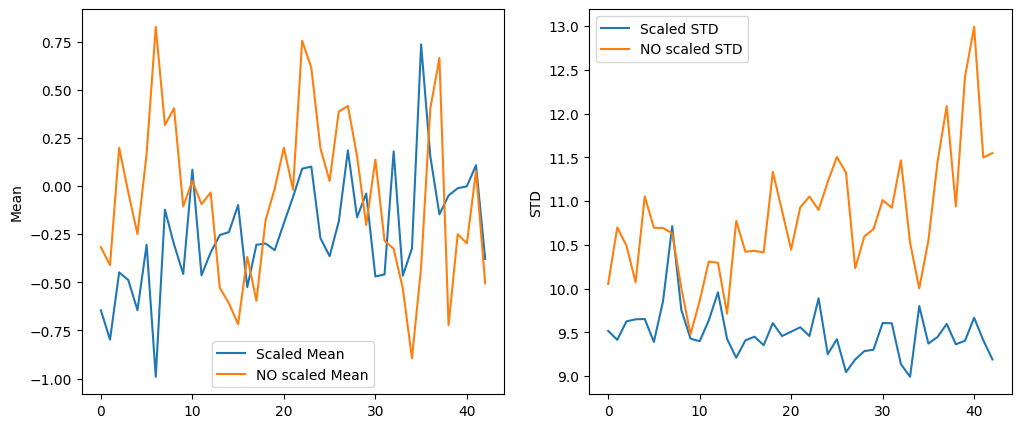

In [6]:
cube_aia,cube_time, data_aia_no_result, cube_alma,time_alma =  result_aia_hmi_data,  time_hmi, data_hmi ,alma_rote, timeutc
n_0_aia, n_f_aia= find_nearest(cube_time, timeutc[0], timeutc[-1], 'IRIS', 'ALMA')
cube_time = cube_time[n_0_aia:n_f_aia]

df_resolution={'AIA94'  : 0.600109,'AIA131' : 0.600698, 
               'AIA171' : 0.599489,'AIA193' : 0.600714,
               'AIA211' : 0.600758,'AIA304' : 0.600165,
               'AIA335' : 0.600737,'AIA1600': 0.609373,
               'AIA1700': 0.612898, 'HMI'   : 0.504349}

mean_scaled  , std_scaled   = [],[]
mean_data_ori, std_data_ori = [],[]


scale_aia=parameters.iloc[4][1]/df_resolution['AIA304']

radio = (parameters.iloc[2][1]/2)*scale_aia
x_resul_sdo, y_resul_sdo=  107,   118
x_0   = round(x_resul_sdo-radio)
x_f   = round(x_resul_sdo+radio)
y_0   = round(y_resul_sdo-radio)
y_f   = round(y_resul_sdo+radio)

aperture                   = aperture_circ_ALMA(cube_alma)

for i in range(0, len(cube_time),1):
    ind=find_nearest_modificated(time_alma, cube_time[i])
    mask_alma=alma_rote[ind].copy()
    mask_alma[mask_alma>7000] =0
    mask_alma[mask_alma>0]=1
    aperture_rescaled   = rescale(aperture , scale_aia, order=0, anti_aliasing=False, preserve_range=True)
    mask_rescale        = rescale(mask_alma, scale_aia, order=0, anti_aliasing=False, preserve_range=True)
    
    x=(data_aia_no_result[n_0_aia+i][y_0:y_f, x_0:x_f])*aperture_rescaled*mask_rescale
    y= cube_aia[i]*mask_alma
    
    mean_data_ori.append(ma.masked_where(x==0.0, x).mean()) 
    std_data_ori.append( ma.masked_where(x==0.0, x).std()) 

    mean_scaled.append(ma.masked_where(y==0.0, y).mean())
    std_scaled.append( ma.masked_where(y==0.0, y).std())

    """
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.title(str(cube_time[i]))
    plt.imshow(x,origin='lower',cmap='sdoaia304')
    plt.subplot(132)
    plt.imshow(y,origin='lower',cmap='sdoaia304')
    #plt.contour(alma_rote[ind],levels=[7000,7500])
    plt.subplot(133)
    plt.title(str(time_alma[ind]))
    plt.imshow(alma_rote[ind], cmap='hot', origin='lower', vmax=10000,vmin=5000)
    plt.contour(alma_rote[ind],levels=[7000])
    print(x.shape)
    plt.show()
    """
  
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(mean_scaled   , label='Scaled Mean')
plt.plot(mean_data_ori , label='NO scaled Mean')
plt.ylabel('Mean')
plt.legend()
plt.subplot(122)
plt.plot(std_scaled  , label='Scaled STD')
plt.ylabel('STD')
plt.plot(std_data_ori, label='NO scaled STD')
plt.legend()
plt.show()



In [14]:
def mean_std_analisis_sdo(cube_aia,cube_time, data_aia_no_result, cube_alma,time_alma):
#cube_aia,cube_time, data_aia_no_result, cube_alma,time_alma =  result_aia_304_data,  time_, data_304 ,alma_rote, timeutc
    n_0_aia, n_f_aia= find_nearest(cube_time, time_alma[0], time_alma[-1], 'SDO', 'ALMA')
    cube_time = cube_time[n_0_aia:n_f_aia]

    df_resolution={'AIA94'  : 0.600109,'AIA131' : 0.600698, 
                'AIA171' : 0.599489,'AIA193' : 0.600714,
                'AIA211' : 0.600758,'AIA304' : 0.600165,
                'AIA335' : 0.600737,'AIA1600': 0.609373,
                'AIA1700': 0.612898, 'HMI'   : 0.504349}

    mean_scaled  , std_scaled   = [],[]
    mean_data_ori, std_data_ori = [],[]
    discre_mean  , discre_sdt    = [],[]

    scale_aia=parameters.iloc[4][1]/df_resolution['AIA304']

    radio = (parameters.iloc[2][1]/2)*scale_aia
    x_resul_sdo, y_resul_sdo=  107,   118
    x_0   = round(x_resul_sdo-radio)
    x_f   = round(x_resul_sdo+radio)
    y_0   = round(y_resul_sdo-radio)
    y_f   = round(y_resul_sdo+radio)

    aperture                   = aperture_circ_ALMA(cube_alma)
    threshold = alma_rote[0][0][0].copy() -650.2055766101175
    for i in range(0, len(cube_time),1):
        ind=find_nearest_modificated(time_alma, cube_time[i])
        mask_alma=alma_rote[ind].copy()
        mask_alma[mask_alma>threshold] =0
        mask_alma[mask_alma>0]=1
        aperture_rescaled   = rescale(aperture , scale_aia, order=0, anti_aliasing=False, preserve_range=True)
        mask_rescale        = rescale(mask_alma, scale_aia, order=0, anti_aliasing=False, preserve_range=True)
        #print(np.max(aperture_rescaled),np.max(mask_rescale))
        #plt.imshow(alma_rote[ind]*mask_alma,origin='lower')
        x = data_aia_no_result[n_0_aia+i][y_0:y_f, x_0:x_f]*aperture_rescaled*mask_rescale
        x= np.abs(x)
        y = cube_aia[i]*mask_alma
        y=np.abs(y)
        #print(np.min(x), np.min(y), np.max(x), np.max(y))
        #print(ind)
        mean_data_ori.append(ma.masked_where(x==0.0, x).mean()) 
        std_data_ori.append( ma.masked_where(x==0.0, x).std()) 

        mean_scaled.append(ma.masked_where(y==0.0, y).mean())
        std_scaled.append( ma.masked_where(y==0.0, y).std())
    


        df_mean=np.abs(ma.masked_where(x==0.0, x).mean() -ma.masked_where(y==0.0, y).mean())
        max_mean = max(ma.masked_where(x==0.0, x).mean(), ma.masked_where(y==0.0, y).mean())
        discre_mean.append(df_mean*100/max_mean)  
        
        df_std =  np.abs(ma.masked_where(x==0.0, x).std() - ma.masked_where(y==0.0, y).std())
        discre_sdt.append( df_std *100/max(ma.masked_where(x==0.0, x).std(), ma.masked_where(y==0.0, y).std())) 


    plt.figure(figsize=(12,5))
    plt.subplot(131)
    plt.plot(mean_scaled   , label='Scaled Mean')
    plt.plot(mean_data_ori , label='NO scaled Mean')
    plt.ylabel('Mean')
    plt.legend()
    plt.subplot(132)
    plt.plot(std_scaled  , label='Scaled STD')
    plt.ylabel('STD')
    plt.plot(std_data_ori, label='NO scaled STD')
    plt.legend()
    plt.subplot(133)
    plt.plot(discre_mean, label='Discre Mean' , color = 'r')
    plt.plot(discre_sdt , label='Discre STD' , color = 'b')

    plt.axhline(y = np.mean(np.array(discre_sdt)) , color = 'b', linestyle  = '--')
    plt.axhline(y = np.mean(np.array(discre_mean)), color = 'r', linestyle = '--')
    plt.show()



______________________________________________________
t_0_SDO = 2018-04-12 15:52:29.140000
t_0_ALMA= 2018-04-12 15:52:31.992187
______________________________________________________
t_f_SDO = 2018-04-12 16:24:41.120000
t_0_ALMA= 2018-04-12 16:24:40.246093
______________________________________________________
posicion_n_0: 85 | posicion_n_f: 246
______________________________________________________


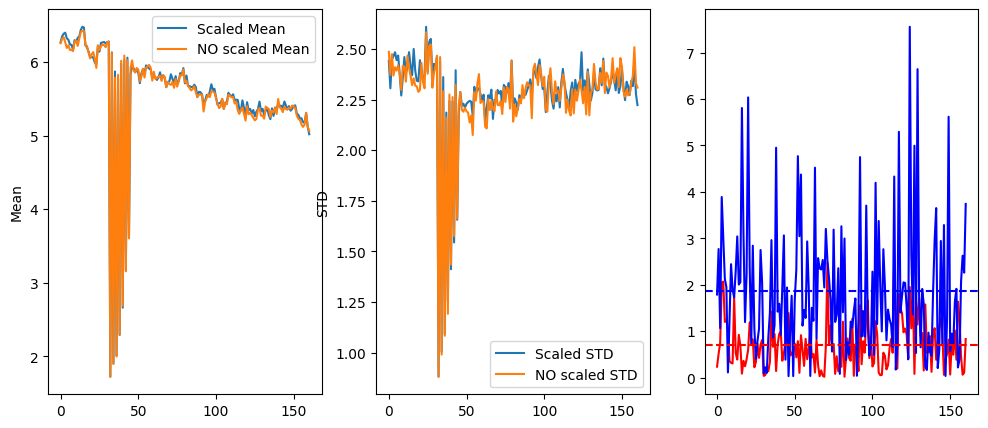

______________________________________________________
t_0_SDO = 2018-04-12 15:52:33.350000
t_0_ALMA= 2018-04-12 15:52:31.992187
______________________________________________________
t_f_SDO = 2018-04-12 16:24:45.350000
t_0_ALMA= 2018-04-12 16:24:40.246093
______________________________________________________
posicion_n_0: 85 | posicion_n_f: 246
______________________________________________________


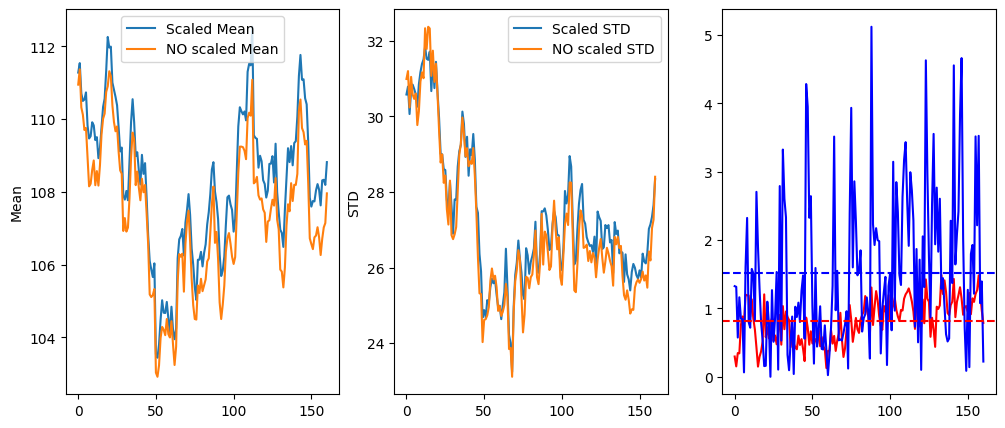

______________________________________________________
t_0_SDO = 2018-04-12 15:52:16.700001
t_0_ALMA= 2018-04-12 15:52:31.992187
______________________________________________________
t_f_SDO = 2018-04-12 16:24:31.700001
t_0_ALMA= 2018-04-12 16:24:40.246093
______________________________________________________
posicion_n_0: 22 | posicion_n_f: 65
______________________________________________________


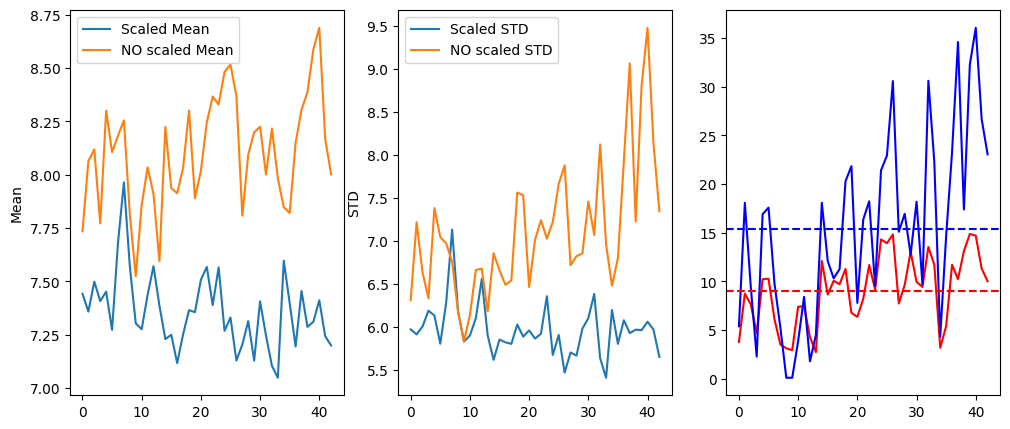

In [15]:
mean_std_analisis_sdo(np.abs(result_aia_304_data),  time_304, data_304 , alma_rote, timeutc)
mean_std_analisis_sdo(np.abs(result_aia_171_data),  time_171, data_171 , alma_rote, timeutc)
mean_std_analisis_sdo(np.abs(result_aia_hmi_data),  time_hmi, data_hmi , alma_rote, timeutc)